<a href="https://colab.research.google.com/github/Nightmare125/Machine-Learning/blob/main/Ensemble_Models_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
!pip install xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, KBinsDiscretizer, PolynomialFeatures
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import (RandomForestClassifier, BaggingClassifier,
                             AdaBoostClassifier, GradientBoostingClassifier,
                             VotingClassifier, StackingClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier



# Part 1: Data Preparation and Exploration


## Task 1.1: Load and Explore the Dataset


Saving winequality-red.csv to winequality-red (2).csv
Dataset Shape: (1599, 12)
First 5 rows of the dataset:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.997

<ipython-input-8-2adf3f1e3fd9>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='quality', data=df, palette="viridis")


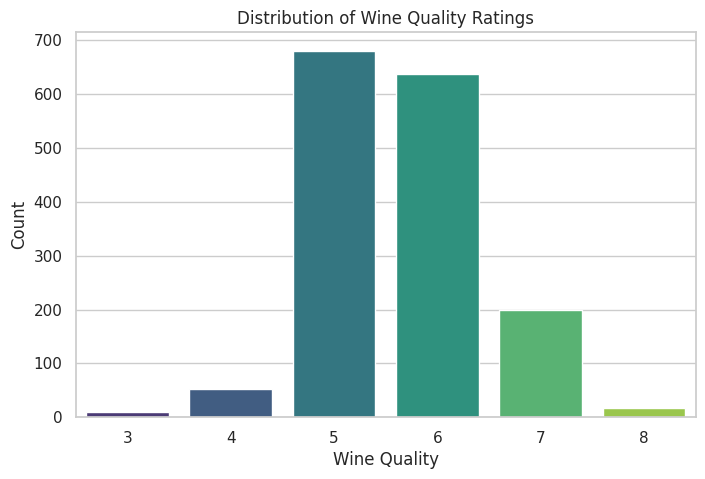

In [8]:
# Set seaborn style
sns.set(style="whitegrid")

# Upload the dataset from your PC
from google.colab import files
uploaded = files.upload()

# Load the dataset (replace the file name if needed)
df = pd.read_csv('winequality-red.csv')

# Display shape of the dataset
print("Dataset Shape:", df.shape)

# Display first 5 rows
print("First 5 rows of the dataset:")
print(df.head())

# Basic info about the dataset
print("Dataset Info:")
print(df.info())

# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

# Visualizing the distribution of wine quality ratings
plt.figure(figsize=(8,5))
sns.countplot(x='quality', data=df, palette="viridis")
plt.title("Distribution of Wine Quality Ratings")
plt.xlabel("Wine Quality")
plt.ylabel("Count")
plt.show()

###**How many samples and features does the dataset have?**
1599 samples and 12 features
###**Are there any missing values?**
No missing values in the dataset
###**What is the distribution of quality ratings?**
Most wines are rated 5 or 6, a decent number are 7, with very few at the extremes like 3, 4, or 8.


## Task 1.2: Exploratory Data Analysis

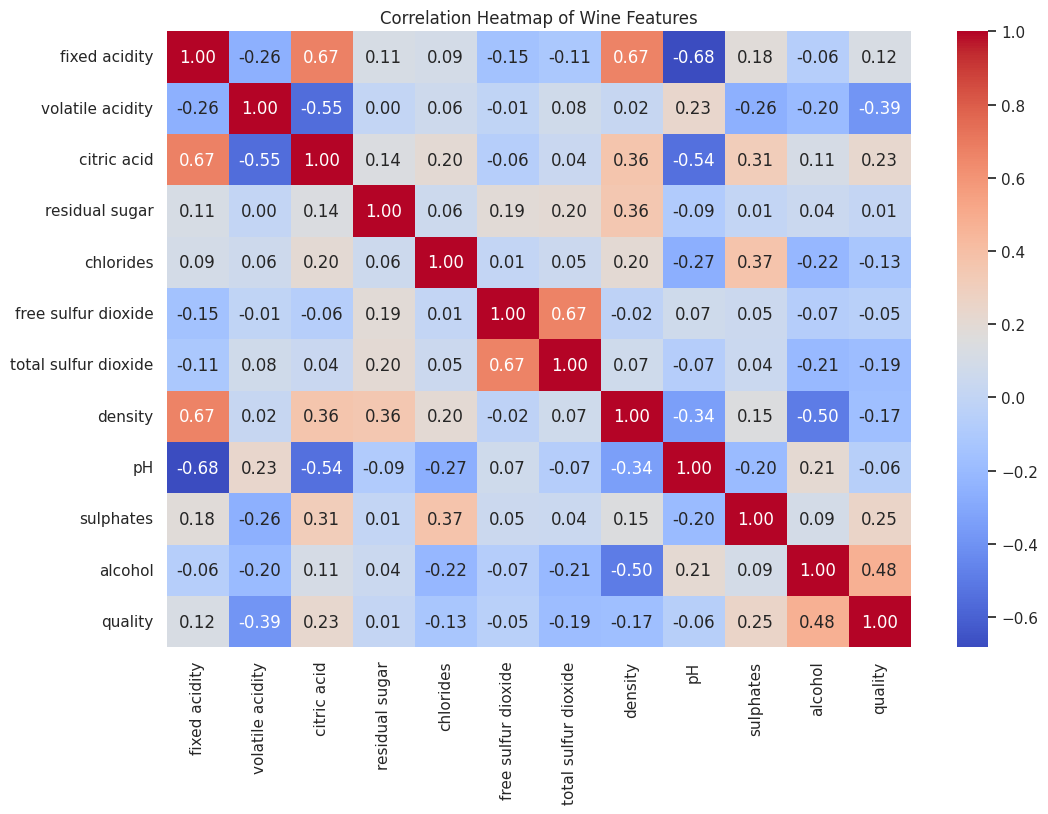

Correlation with quality:
 quality                 1.000000
alcohol                 0.476166
sulphates               0.251397
citric acid             0.226373
fixed acidity           0.124052
residual sugar          0.013732
free sulfur dioxide    -0.050656
pH                     -0.057731
chlorides              -0.128907
density                -0.174919
total sulfur dioxide   -0.185100
volatile acidity       -0.390558
Name: quality, dtype: float64


In [9]:
# Correlation matrix
corr_matrix = df.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Wine Features")
plt.show()

# Correlation with 'quality'
corr_with_quality = corr_matrix['quality'].sort_values(ascending=False)
print("Correlation with quality:\n", corr_with_quality)


### Visualizations Exploring Feature-Quality Relationships

<ipython-input-10-8682b67b9e51>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='quality', y='alcohol', data=df, palette='muted')


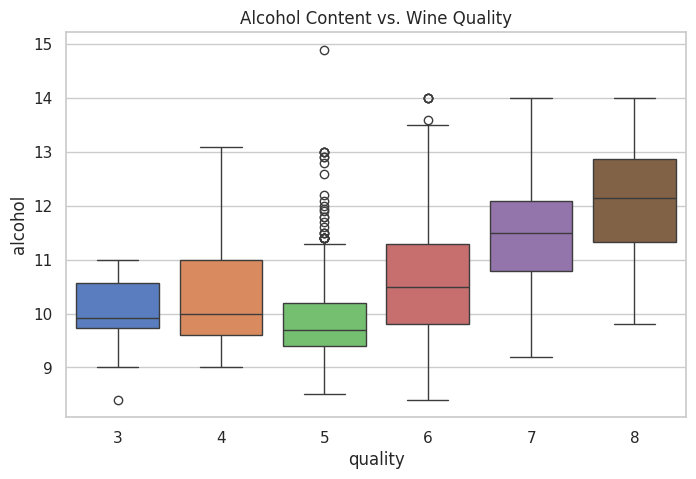

In [10]:
plt.figure(figsize=(8,5))
sns.boxplot(x='quality', y='alcohol', data=df, palette='muted')
plt.title("Alcohol Content vs. Wine Quality")
plt.show()


<ipython-input-11-4fbbc24367ef>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='quality', y='volatile acidity', data=df, palette='muted')


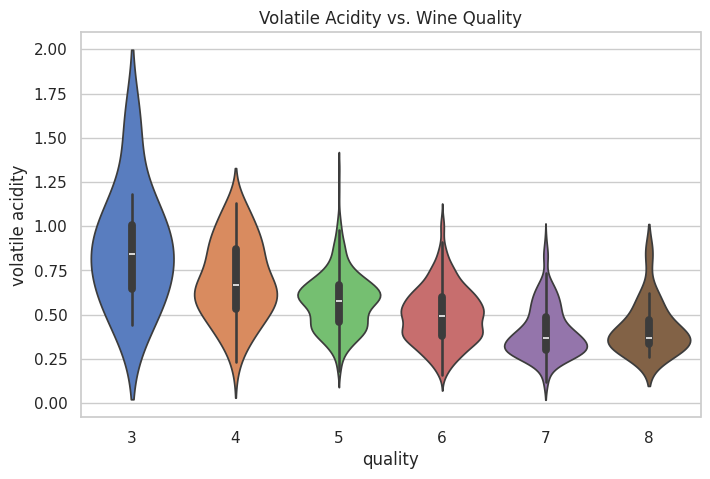

In [11]:
plt.figure(figsize=(8,5))
sns.violinplot(x='quality', y='volatile acidity', data=df, palette='muted')
plt.title("Volatile Acidity vs. Wine Quality")
plt.show()


### **Identify the top 3 features most correlated with wine quality**
1.   Alcohol (Correlation: +0.476)
2.   Sulphates (Correlation: +0.251)
3.   Citric Acid (Correlation: +0.226)









## Task 1.3: Data Preprocessing

In [12]:
# Convert quality to binary classification
df['quality_label'] = df['quality'].apply(lambda x: 1 if x >= 7 else 0)

# Check new label distribution
print(df['quality_label'].value_counts())

# Features and target
X = df.drop(['quality', 'quality_label'], axis=1)
y = df['quality_label']

# Split data into training and testing sets (stratify to maintain class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Check distribution in both sets
print("Training set class distribution:\n", y_train.value_counts(normalize=True))
print("Test set class distribution:\n", y_test.value_counts(normalize=True))

# Initialize scaler
scaler = StandardScaler()

# Fit on training data, transform both train and test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Check shape of scaled data
print("X_train shape:", X_train_scaled.shape)
print("X_test shape:", X_test_scaled.shape)

quality_label
0    1382
1     217
Name: count, dtype: int64
Training set class distribution:
 quality_label
0    0.863956
1    0.136044
Name: proportion, dtype: float64
Test set class distribution:
 quality_label
0    0.865625
1    0.134375
Name: proportion, dtype: float64
X_train shape: (1279, 11)
X_test shape: (320, 11)


# Part 2: Bagging Techniques

## Random Forest

Random Forest Accuracy: 0.9375

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       277
           1       0.93      0.58      0.71        43

    accuracy                           0.94       320
   macro avg       0.93      0.79      0.84       320
weighted avg       0.94      0.94      0.93       320



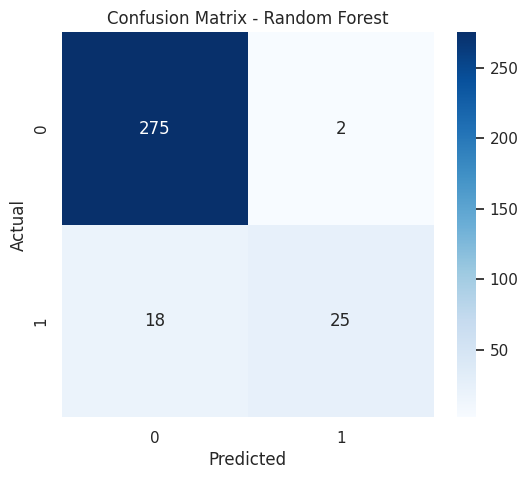

<ipython-input-17-eecb5cbf831c>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp.values, y=feat_imp.index, palette="viridis")


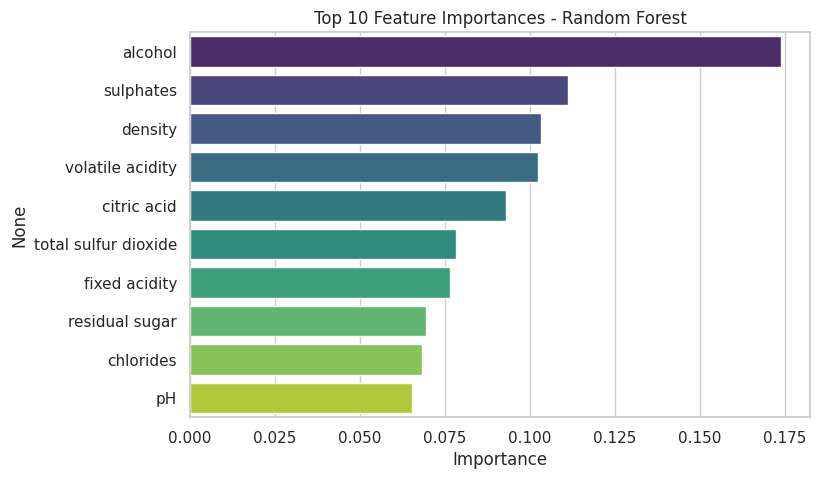

max_depth=5: Accuracy = 0.9031
max_depth=10: Accuracy = 0.9313
max_depth=15: Accuracy = 0.9375
max_depth=None: Accuracy = 0.9375


In [17]:
# Initialize Random Forest with 100 trees
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_clf.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = rf_clf.predict(X_test_scaled)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix plot
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Feature importance plot (top 10)
importances = rf_clf.feature_importances_
features = X.columns
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False).head(10)

plt.figure(figsize=(8,5))
sns.barplot(x=feat_imp.values, y=feat_imp.index, palette="viridis")
plt.title("Top 10 Feature Importances - Random Forest")
plt.xlabel("Importance")
plt.show()

depths = [5, 10, 15, None]
for depth in depths:
    rf = RandomForestClassifier(n_estimators=100, max_depth=depth, random_state=42)
    rf.fit(X_train_scaled, y_train)
    y_pred_depth = rf.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred_depth)
    print(f"max_depth={depth}: Accuracy = {acc:.4f}")

## Generic Bagging Implementation

Bagging with Decision Tree Accuracy: 0.9281
Bagging with Logistic Regression Accuracy: 0.8906


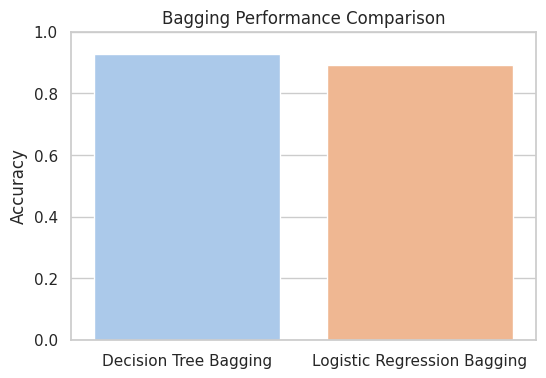

In [19]:
# Bagging with Decision Tree (50 estimators, max_depth=8)
dt_base = DecisionTreeClassifier(max_depth=8, random_state=42)
bagging_dt = BaggingClassifier(estimator=dt_base, n_estimators=50, random_state=42)
bagging_dt.fit(X_train_scaled, y_train)
y_pred_dt = bagging_dt.predict(X_test_scaled)
acc_dt = accuracy_score(y_test, y_pred_dt)
print(f"Bagging with Decision Tree Accuracy: {acc_dt:.4f}")

# Bagging with Logistic Regression (50 estimators)
lr_base = LogisticRegression(max_iter=1000, random_state=42)
bagging_lr = BaggingClassifier(estimator=lr_base, n_estimators=50, random_state=42)
bagging_lr.fit(X_train_scaled, y_train)
y_pred_lr = bagging_lr.predict(X_test_scaled)
acc_lr = accuracy_score(y_test, y_pred_lr)
print(f"Bagging with Logistic Regression Accuracy: {acc_lr:.4f}")

# Bar chart comparing accuracies
plt.figure(figsize=(6,4))
sns.barplot(x=['Decision Tree Bagging', 'Logistic Regression Bagging'],
            y=[acc_dt, acc_lr], palette='pastel')
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Bagging Performance Comparison")
plt.show()

## Bagging Experiments

Bagging with KNN Accuracy: 0.8938
Bagging with SVM Accuracy: 0.8656


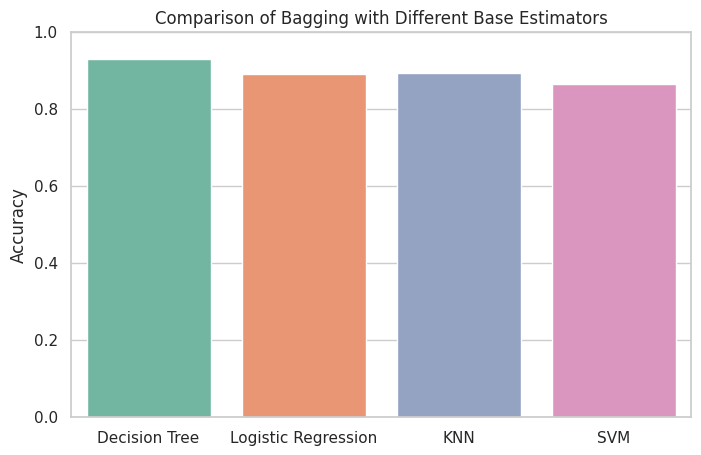

In [20]:
# Bagging with KNN (k=5)
knn_base = KNeighborsClassifier(n_neighbors=5)
bagging_knn = BaggingClassifier(estimator=knn_base, n_estimators=50, random_state=42)
bagging_knn.fit(X_train_scaled, y_train)
y_pred_knn = bagging_knn.predict(X_test_scaled)
acc_knn = accuracy_score(y_test, y_pred_knn)
print(f"Bagging with KNN Accuracy: {acc_knn:.4f}")

# Bagging with SVM (use linear kernel for speed; no probability needed here)
svm_base = SVC(kernel='linear', probability=False, random_state=42)
bagging_svm = BaggingClassifier(estimator=svm_base, n_estimators=50, random_state=42)
bagging_svm.fit(X_train_scaled, y_train)
y_pred_svm = bagging_svm.predict(X_test_scaled)
acc_svm = accuracy_score(y_test, y_pred_svm)
print(f"Bagging with SVM Accuracy: {acc_svm:.4f}")

# Existing accuracies from previous task (Decision Tree and Logistic Regression)
# If you haven’t saved them yet, you can re-run or save here:
# acc_dt, acc_lr

# Collect accuracies
models = ['Decision Tree', 'Logistic Regression', 'KNN', 'SVM']
accuracies = [acc_dt, acc_lr, acc_knn, acc_svm]

# Plotting the comparison
plt.figure(figsize=(8,5))
sns.barplot(x=models, y=accuracies, palette='Set2')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Comparison of Bagging with Different Base Estimators')
plt.show()

# Part 3: Boosting Techniques

## AdaBoost Implementation


AdaBoost Accuracy: 0.9000

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.99      0.94       277
           1       0.79      0.35      0.48        43

    accuracy                           0.90       320
   macro avg       0.85      0.67      0.71       320
weighted avg       0.89      0.90      0.88       320



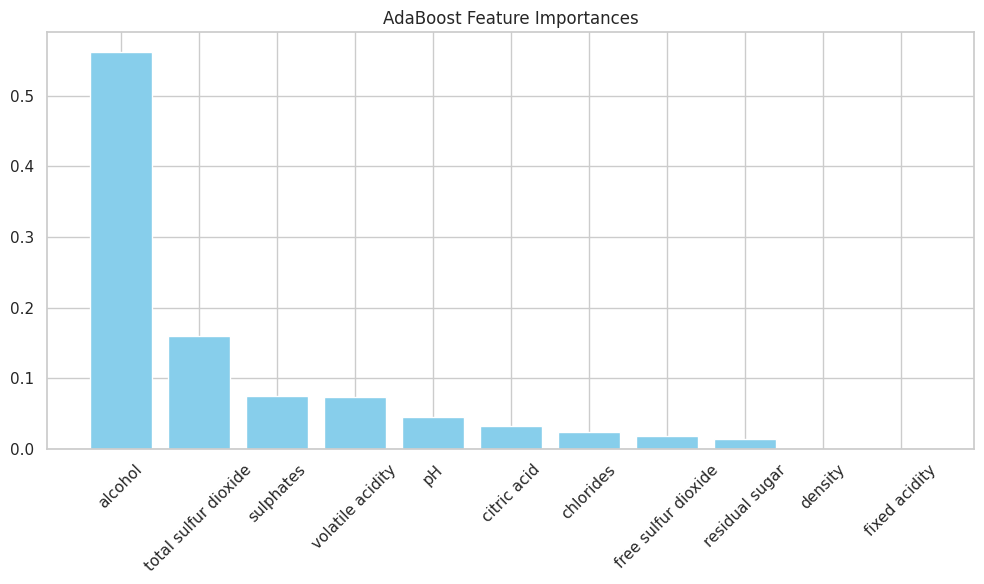

In [22]:
# Create Decision Tree stump as base estimator
dt_stump = DecisionTreeClassifier(max_depth=1, random_state=42)

# Create AdaBoost classifier
ada_clf = AdaBoostClassifier(
    estimator=dt_stump,
    n_estimators=50,
    learning_rate=1.0,
    random_state=42
)

# Train the AdaBoost model
ada_clf.fit(X_train_scaled, y_train)

# Make predictions
y_pred_ada = ada_clf.predict(X_test_scaled)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred_ada)
print(f"AdaBoost Accuracy: {accuracy:.4f}\n")
print("Classification Report:\n", classification_report(y_test, y_pred_ada))

# Plot feature importances
importances = ada_clf.feature_importances_
features = df.columns[:-1]  # all columns except 'quality'

plt.figure(figsize=(10,6))
indices = np.argsort(importances)[::-1]  # descending order

plt.title("AdaBoost Feature Importances")
plt.bar(range(len(importances)), importances[indices], align='center', color='skyblue')
plt.xticks(range(len(importances)), [features[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()

## Gradient Boosting

In [25]:
# Initialize Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train the Gradient Boosting model
gb_clf.fit(X_train_scaled, y_train)

# Predict on test data
y_pred_gb = gb_clf.predict(X_test_scaled)

# Evaluate Gradient Boosting performance
accuracy_gb = accuracy_score(y_test, y_pred_gb)
precision_gb = precision_score(y_test, y_pred_gb)
recall_gb = recall_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb)

print(f"Gradient Boosting Accuracy: {accuracy_gb:.4f}\n")
print("Gradient Boosting Classification Report:\n", classification_report(y_test, y_pred_gb))

# AdaBoost metrics (assuming y_pred_ada and ada_clf from previous task)
accuracy_ada = accuracy_score(y_test, y_pred_ada)
precision_ada = precision_score(y_test, y_pred_ada)
recall_ada = recall_score(y_test, y_pred_ada)
f1_ada = f1_score(y_test, y_pred_ada)

# Create comparison table
comparison_df = pd.DataFrame({
    'Model': ['AdaBoost', 'Gradient Boosting'],
    'Accuracy': [accuracy_ada, accuracy_gb],
    'Precision': [precision_ada, precision_gb],
    'Recall': [recall_ada, recall_gb],
    'F1 Score': [f1_ada, f1_gb]
})

print(comparison_df)

Gradient Boosting Accuracy: 0.9156

Gradient Boosting Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.95       277
           1       0.79      0.51      0.62        43

    accuracy                           0.92       320
   macro avg       0.86      0.74      0.79       320
weighted avg       0.91      0.92      0.91       320

               Model  Accuracy  Precision    Recall  F1 Score
0           AdaBoost  0.900000   0.789474  0.348837  0.483871
1  Gradient Boosting  0.915625   0.785714  0.511628  0.619718


##  XGBoost Implementation


XGBoost Classifier Performance:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       277
           1       0.83      0.47      0.60        43

    accuracy                           0.92       320
   macro avg       0.88      0.73      0.77       320
weighted avg       0.91      0.92      0.91       320



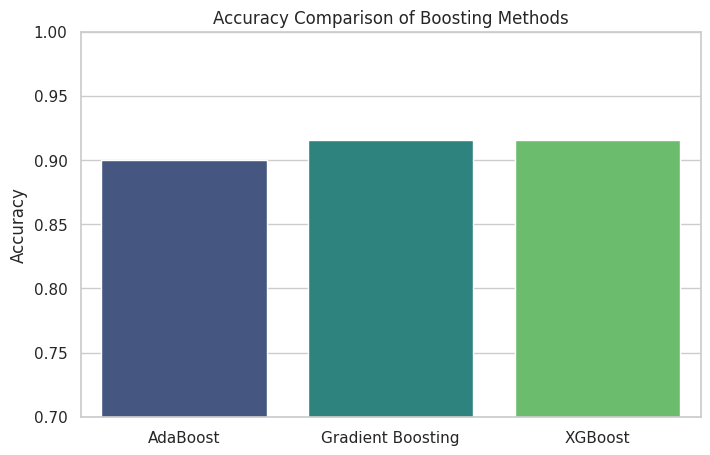

In [27]:
# Create XGBoost classifier
xgb_clf = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train XGBoost model
xgb_clf.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_xgb = xgb_clf.predict(X_test_scaled)

# Evaluate XGBoost performance
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

print("XGBoost Classifier Performance:")
print(classification_report(y_test, y_pred_xgb))

# Assuming you already have AdaBoost and Gradient Boosting results:
# For example:
# accuracy_ada, precision_ada, recall_ada, f1_ada
# accuracy_gb, precision_gb, recall_gb, f1_gb

# Create a comparison bar chart for accuracy of all three boosting methods
import matplotlib.pyplot as plt

methods = ['AdaBoost', 'Gradient Boosting', 'XGBoost']
accuracies = [accuracy_ada, accuracy_gb, accuracy_xgb]

plt.figure(figsize=(8,5))
sns.barplot(x=methods, y=accuracies, palette='viridis')
plt.title("Accuracy Comparison of Boosting Methods")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1.0)
plt.show()

## Boosting Hyperparameter Tuning

In [28]:
# Define the model (XGBoost here)
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid,
                           scoring='accuracy', cv=5, n_jobs=-1, verbose=2)

# Fit GridSearchCV to training data
grid_search.fit(X_train_scaled, y_train)

# Best hyperparameters
print("Best Parameters found:", grid_search.best_params_)

# Evaluate best model on test data
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test_scaled)

from sklearn.metrics import accuracy_score, classification_report

accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Test Accuracy with best parameters: {accuracy_best:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_best))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters found: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Test Accuracy with best parameters: 0.9500
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97       277
           1       0.89      0.72      0.79        43

    accuracy                           0.95       320
   macro avg       0.92      0.85      0.88       320
weighted avg       0.95      0.95      0.95       320



# Part 4: Voting Classifiers


## Individual Base Classifiers


Logistic Regression Accuracy: 0.8938
Random Forest Accuracy: 0.9375
SVC Accuracy: 0.9000


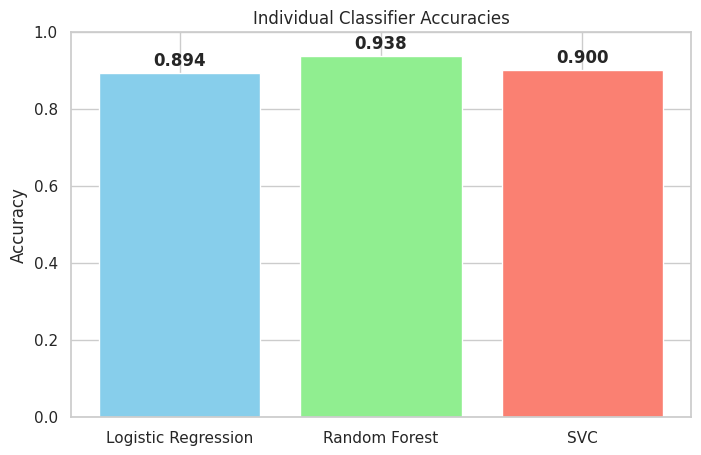

In [29]:
# Initialize classifiers
log_reg = LogisticRegression(max_iter=1000, random_state=42)
rf_clf = RandomForestClassifier(n_estimators=50, random_state=42)
svc_clf = SVC(random_state=42)

# Train classifiers
log_reg.fit(X_train_scaled, y_train)
rf_clf.fit(X_train_scaled, y_train)
svc_clf.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_log = log_reg.predict(X_test_scaled)
y_pred_rf = rf_clf.predict(X_test_scaled)
y_pred_svc = svc_clf.predict(X_test_scaled)

# Calculate accuracies
acc_log = accuracy_score(y_test, y_pred_log)
acc_rf = accuracy_score(y_test, y_pred_rf)
acc_svc = accuracy_score(y_test, y_pred_svc)

print(f"Logistic Regression Accuracy: {acc_log:.4f}")
print(f"Random Forest Accuracy: {acc_rf:.4f}")
print(f"SVC Accuracy: {acc_svc:.4f}")

# Plot accuracies
models = ['Logistic Regression', 'Random Forest', 'SVC']
accuracies = [acc_log, acc_rf, acc_svc]

plt.figure(figsize=(8,5))
plt.bar(models, accuracies, color=['skyblue', 'lightgreen', 'salmon'])
plt.ylim([0, 1])
plt.title("Individual Classifier Accuracies")
plt.ylabel("Accuracy")
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center', fontweight='bold')
plt.show()

## Hard Voting Implementation

Hard Voting Classifier Accuracy: 0.9062
Logistic Regression Accuracy: 0.8938
Random Forest Accuracy: 0.9375
SVC Accuracy: 0.9000


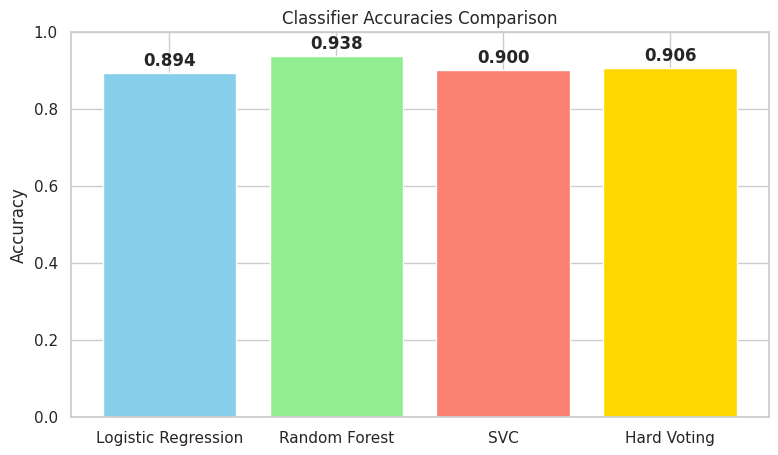

In [30]:
# Create the individual classifiers again (if not already created)
log_reg = LogisticRegression(max_iter=1000, random_state=42)
rf_clf = RandomForestClassifier(n_estimators=50, random_state=42)
svc_clf = SVC(probability=False, random_state=42)  # Hard voting doesn’t need probability=True

# Create the Hard Voting Classifier
voting_clf = VotingClassifier(
    estimators=[('lr', log_reg), ('rf', rf_clf), ('svc', svc_clf)],
    voting='hard'  # hard voting mode
)

# Train the voting classifier
voting_clf.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_voting = voting_clf.predict(X_test_scaled)

# Evaluate accuracy
acc_voting = accuracy_score(y_test, y_pred_voting)
print(f"Hard Voting Classifier Accuracy: {acc_voting:.4f}")

# For comparison, print individual classifier accuracies again
log_reg.fit(X_train_scaled, y_train)
rf_clf.fit(X_train_scaled, y_train)
svc_clf.fit(X_train_scaled, y_train)

acc_log = accuracy_score(y_test, log_reg.predict(X_test_scaled))
acc_rf = accuracy_score(y_test, rf_clf.predict(X_test_scaled))
acc_svc = accuracy_score(y_test, svc_clf.predict(X_test_scaled))

print(f"Logistic Regression Accuracy: {acc_log:.4f}")
print(f"Random Forest Accuracy: {acc_rf:.4f}")
print(f"SVC Accuracy: {acc_svc:.4f}")

# Visualization
import matplotlib.pyplot as plt

models = ['Logistic Regression', 'Random Forest', 'SVC', 'Hard Voting']
accuracies = [acc_log, acc_rf, acc_svc, acc_voting]

plt.figure(figsize=(9,5))
plt.bar(models, accuracies, color=['skyblue', 'lightgreen', 'salmon', 'gold'])
plt.ylim([0, 1])
plt.title("Classifier Accuracies Comparison")
plt.ylabel("Accuracy")
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center', fontweight='bold')
plt.show()

## Soft Voting Implementation


Soft Voting Classifier Accuracy: 0.9094
Hard Voting Classifier Accuracy: 0.9062


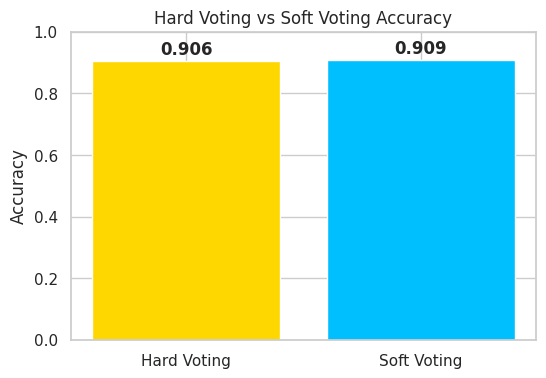

In [31]:
# Create base classifiers with SVC probability=True for soft voting
log_reg = LogisticRegression(max_iter=1000, random_state=42)
rf_clf = RandomForestClassifier(n_estimators=50, random_state=42)
svc_clf = SVC(probability=True, random_state=42)  # Enable probability estimates

# Create Soft Voting Classifier
soft_voting_clf = VotingClassifier(
    estimators=[('lr', log_reg), ('rf', rf_clf), ('svc', svc_clf)],
    voting='soft'  # soft voting mode
)

# Train the soft voting classifier
soft_voting_clf.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_soft = soft_voting_clf.predict(X_test_scaled)
acc_soft = accuracy_score(y_test, y_pred_soft)
print(f"Soft Voting Classifier Accuracy: {acc_soft:.4f}")

# For comparison, re-train hard voting classifier (if needed)
hard_voting_clf = VotingClassifier(
    estimators=[('lr', log_reg), ('rf', rf_clf), ('svc', svc_clf)],
    voting='hard'
)
hard_voting_clf.fit(X_train_scaled, y_train)
y_pred_hard = hard_voting_clf.predict(X_test_scaled)
acc_hard = accuracy_score(y_test, y_pred_hard)
print(f"Hard Voting Classifier Accuracy: {acc_hard:.4f}")

# Comparison visualization
import matplotlib.pyplot as plt

models = ['Hard Voting', 'Soft Voting']
accuracies = [acc_hard, acc_soft]

plt.figure(figsize=(6,4))
plt.bar(models, accuracies, color=['gold', 'deepskyblue'])
plt.ylim([0, 1])
plt.title("Hard Voting vs Soft Voting Accuracy")
plt.ylabel("Accuracy")
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center', fontweight='bold')
plt.show()

## Voting Ensemble Analysis

                 Model  Accuracy
0  Logistic Regression  0.893750
1        Random Forest  0.937500
2                  SVC  0.900000
3          Hard Voting  0.906250
4          Soft Voting  0.909375


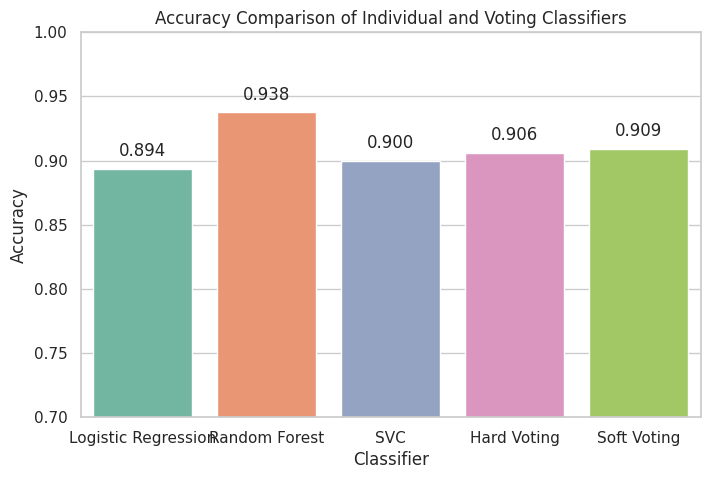

In [32]:
# Train individual classifiers if not trained already
log_reg.fit(X_train_scaled, y_train)
rf_clf.fit(X_train_scaled, y_train)
svc_clf.fit(X_train_scaled, y_train)

# Predictions for individuals
y_pred_lr = log_reg.predict(X_test_scaled)
y_pred_rf = rf_clf.predict(X_test_scaled)
y_pred_svc = svc_clf.predict(X_test_scaled)

# Accuracy for individuals
acc_lr = accuracy_score(y_test, y_pred_lr)
acc_rf = accuracy_score(y_test, y_pred_rf)
acc_svc = accuracy_score(y_test, y_pred_svc)

# Hard voting
hard_voting_clf.fit(X_train_scaled, y_train)
y_pred_hard = hard_voting_clf.predict(X_test_scaled)
acc_hard = accuracy_score(y_test, y_pred_hard)

# Soft voting
soft_voting_clf.fit(X_train_scaled, y_train)
y_pred_soft = soft_voting_clf.predict(X_test_scaled)
acc_soft = accuracy_score(y_test, y_pred_soft)

# Create a summary DataFrame
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'SVC', 'Hard Voting', 'Soft Voting'],
    'Accuracy': [acc_lr, acc_rf, acc_svc, acc_hard, acc_soft]
})

print(results)

# Visualization
plt.figure(figsize=(8,5))
sns.barplot(x='Model', y='Accuracy', data=results, palette='Set2')
plt.ylim(0.7, 1)
plt.title("Accuracy Comparison of Individual and Voting Classifiers")
plt.ylabel("Accuracy")
plt.xlabel("Classifier")
for i, val in enumerate(results['Accuracy']):
    plt.text(i, val + 0.01, f"{val:.3f}", ha='center')
plt.show()

# Part 5: Stacking


## Basic Stacking Implementation


In [33]:
# Define base models (Level 1)
base_estimators = [
    ('rf', RandomForestClassifier(n_estimators=50, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=50, random_state=42)),
    ('svc', SVC(probability=True, random_state=42))
]

# Define meta-learner (Level 2)
meta_learner = LogisticRegression(random_state=42)

# Create stacking classifier with 5-fold CV internally
stacking_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=meta_learner,
    cv=5,
    n_jobs=-1,
    passthrough=False  # can set True to add original features to meta-learner input if desired
)

# Train stacking classifier on training data
stacking_clf.fit(X_train_scaled, y_train)

# Evaluate on test data
y_pred_stack = stacking_clf.predict(X_test_scaled)

# Metrics
accuracy = accuracy_score(y_test, y_pred_stack)
print(f"Stacking Classifier Accuracy: {accuracy:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_pred_stack))

# Optional: cross-validation score on training data
cv_scores = cross_val_score(stacking_clf, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"5-Fold CV Accuracy (Train): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Stacking Classifier Accuracy: 0.9344
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       277
           1       0.89      0.58      0.70        43

    accuracy                           0.93       320
   macro avg       0.92      0.79      0.83       320
weighted avg       0.93      0.93      0.93       320

5-Fold CV Accuracy (Train): 0.8929 ± 0.0117


## Meta-Learner Comparison

Training Stacking Classifier with meta-learner: Logistic Regression
Logistic Regression Accuracy: 0.9344
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       277
           1       0.89      0.58      0.70        43

    accuracy                           0.93       320
   macro avg       0.92      0.79      0.83       320
weighted avg       0.93      0.93      0.93       320

----------------------------------------
Training Stacking Classifier with meta-learner: Random Forest
Random Forest Accuracy: 0.9344
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       277
           1       0.96      0.53      0.69        43

    accuracy                           0.93       320
   macro avg       0.95      0.77      0.82       320
weighted avg       0.94      0.93      0.93       320

----------------------------------------
Training Stacking Classifier with meta-learner: XGBoost
XGBoost Ac

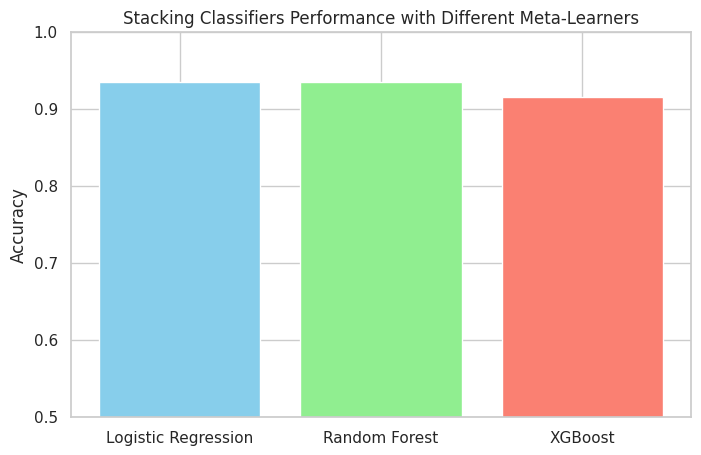

In [34]:
# Base models (Level 1) — same for all stacking classifiers
base_estimators = [
    ('rf', RandomForestClassifier(n_estimators=50, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=50, random_state=42)),
    ('svc', SVC(probability=True, random_state=42))
]

# Define meta-learners
meta_learners = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=50, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=50, use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = {}

for name, meta_learner in meta_learners.items():
    print(f"Training Stacking Classifier with meta-learner: {name}")

    stacking_clf = StackingClassifier(
        estimators=base_estimators,
        final_estimator=meta_learner,
        cv=5,
        n_jobs=-1,
        passthrough=False
    )

    stacking_clf.fit(X_train_scaled, y_train)
    y_pred = stacking_clf.predict(X_test_scaled)

    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

    print(f"{name} Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))
    print("-" * 40)

# Summary comparison

plt.figure(figsize=(8,5))
plt.bar(results.keys(), results.values(), color=['skyblue', 'lightgreen', 'salmon'])
plt.title("Stacking Classifiers Performance with Different Meta-Learners")
plt.ylabel("Accuracy")
plt.ylim([0.5, 1])
plt.show()

## Advanced Stacking Experiment

Advanced Stacking Accuracy: 0.9344
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       277
           1       0.82      0.65      0.73        43

    accuracy                           0.93       320
   macro avg       0.89      0.81      0.84       320
weighted avg       0.93      0.93      0.93       320

Simple Stacking Accuracy: 0.9156


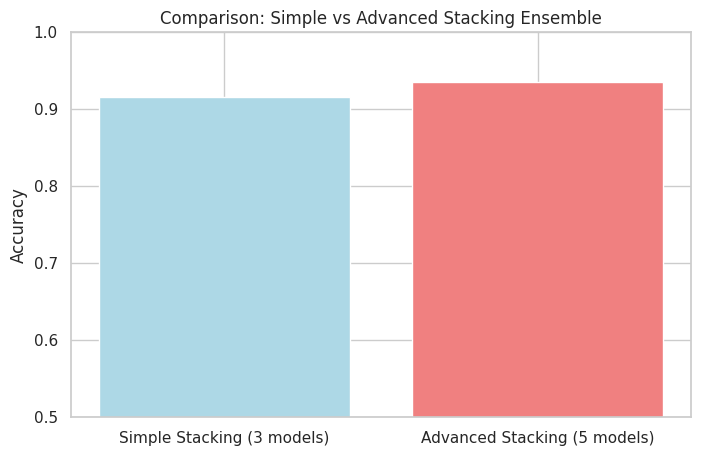

In [35]:
# Add KNN and AdaBoost to the previous base models (Random Forest, Gradient Boosting, SVC)
base_estimators_advanced = [
    ('rf', RandomForestClassifier(n_estimators=50, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=50, random_state=42)),
    ('svc', SVC(probability=True, random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('ada', AdaBoostClassifier(n_estimators=50, random_state=42))
]

# Use the best meta-learner from Task 5.2
# Suppose XGBoost performed best (replace with your actual best meta-learner if different)
best_meta_learner = XGBClassifier(n_estimators=50, use_label_encoder=False, eval_metric='logloss', random_state=42)

# Create the advanced stacking classifier
stacking_clf_advanced = StackingClassifier(
    estimators=base_estimators_advanced,
    final_estimator=best_meta_learner,
    cv=5,
    n_jobs=-1,
    passthrough=False
)

# Train the advanced stacking classifier
stacking_clf_advanced.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_advanced = stacking_clf_advanced.predict(X_test_scaled)

accuracy_advanced = accuracy_score(y_test, y_pred_advanced)
print(f"Advanced Stacking Accuracy: {accuracy_advanced:.4f}")
print(classification_report(y_test, y_pred_advanced))

# For comparison, retrain the simpler 3-model stacking (if not saved)
stacking_clf_simple = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=50, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=50, random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ],
    final_estimator=best_meta_learner,
    cv=5,
    n_jobs=-1,
    passthrough=False
)

stacking_clf_simple.fit(X_train_scaled, y_train)
y_pred_simple = stacking_clf_simple.predict(X_test_scaled)
accuracy_simple = accuracy_score(y_test, y_pred_simple)
print(f"Simple Stacking Accuracy: {accuracy_simple:.4f}")

# Visual comparison
import matplotlib.pyplot as plt

results = {
    'Simple Stacking (3 models)': accuracy_simple,
    'Advanced Stacking (5 models)': accuracy_advanced
}

plt.figure(figsize=(8,5))
plt.bar(results.keys(), results.values(), color=['lightblue', 'lightcoral'])
plt.ylabel('Accuracy')
plt.title('Comparison: Simple vs Advanced Stacking Ensemble')
plt.ylim([0.5, 1])
plt.show()

# Part 6: Comprehensive Model Comparison

## Results Compilation

In [45]:
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
accuracy_best_bagging = accuracy_dt
accuracy_ada = accuracy_score(y_test, y_pred_ada)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
best_params = {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
xgb_best = XGBClassifier(n_estimators=best_params['n_estimators'],
                         learning_rate=best_params['learning_rate'],
                         max_depth=best_params['max_depth'],
                         use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_best.fit(X_train_scaled, y_train)
y_pred_xgb_tuned = xgb_best.predict(X_test_scaled)
accuracy_xgb_tuned = accuracy_score(y_test, y_pred_xgb_tuned)
y_pred_hard_voting = hard_voting_clf.predict(X_test_scaled)
y_pred_soft_voting = soft_voting_clf.predict(X_test_scaled)
# Define base learners
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=50, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=50, random_state=42)),
    ('svc', SVC(probability=True, random_state=42))
]

# Define meta learner (e.g., Logistic Regression or whichever performed best)
meta_learner = LogisticRegression()

# Create stacking classifier
from sklearn.ensemble import StackingClassifier
best_stacking_clf = StackingClassifier(estimators=base_learners, final_estimator=meta_learner, cv=5)

# Train stacking classifier
best_stacking_clf.fit(X_train_scaled, y_train)

# Now you can predict
y_pred_best_stacking = best_stacking_clf.predict(X_test_scaled)
y_pred_best_stacking = best_stacking_clf.predict(X_test_scaled)
accuracy_hard_voting = accuracy_score(y_test, y_pred_hard_voting)
accuracy_soft_voting = accuracy_score(y_test, y_pred_soft_voting)
accuracy_best_stacking = accuracy_score(y_test, y_pred_best_stacking)

In [46]:
# Results dictionary — fill in your actual variable values here
results = {
    'Random Forest': accuracy_rf,
    'Best Bagging Approach': accuracy_best_bagging,
    'AdaBoost': accuracy_ada,
    'Gradient Boosting': accuracy_gb,
    'XGBoost (Tuned)': accuracy_xgb_tuned,
    'Hard Voting': accuracy_hard_voting,
    'Soft Voting': accuracy_soft_voting,
    'Best Stacking Approach': accuracy_best_stacking
}

# Sort results from highest to lowest
sorted_results = dict(sorted(results.items(), key=lambda item: item[1], reverse=True))

# Display the sorted results
for model, acc in sorted_results.items():
    print(f"{model}: {acc:.4f}")

XGBoost (Tuned): 0.9500
Random Forest: 0.9375
Best Stacking Approach: 0.9344
Best Bagging Approach: 0.9281
Gradient Boosting: 0.9156
Soft Voting: 0.9094
Hard Voting: 0.9062
AdaBoost: 0.9000


## Performance Visualization


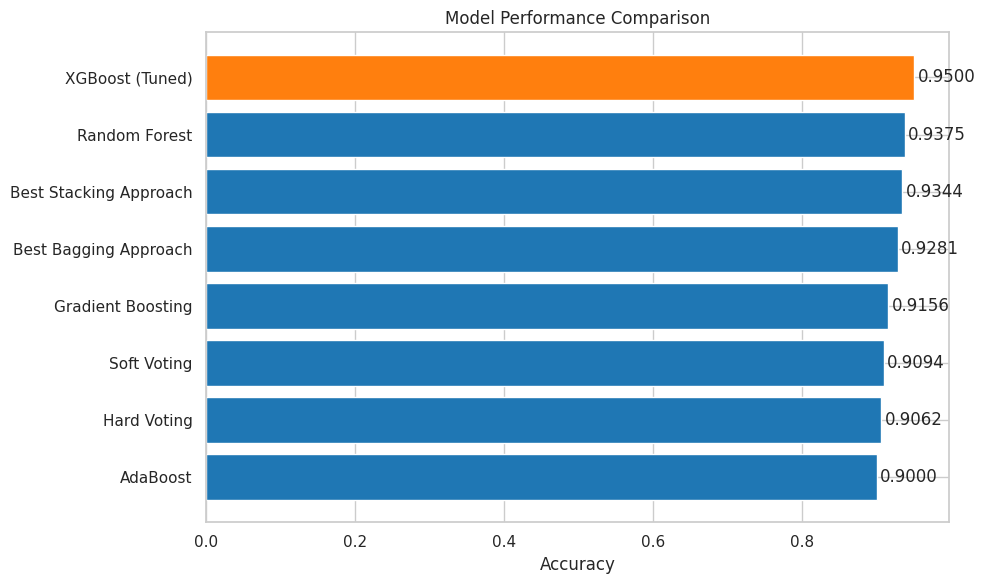

In [47]:
models = list(sorted_results.keys())
accuracies = list(sorted_results.values())

# Highlight the top-performing model
colors = ['tab:blue'] * len(models)
colors[0] = 'tab:orange'  # Highlight the best model (first after sorting descending)

plt.figure(figsize=(10, 6))
bars = plt.barh(models, accuracies, color=colors)
plt.xlabel('Accuracy')
plt.title('Model Performance Comparison')

# Add accuracy labels to the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height()/2,
             f'{width:.4f}', va='center')

plt.gca().invert_yaxis()  # Highest accuracy on top
plt.tight_layout()
plt.show()

## Cross-Validation Analysis

In [58]:
top_models = {
    'XGBoost Tuned': xgb_clf,
    'Random Forest': rf_clf,
    'Best Stacking': best_stacking_clf,
    'Hard Voting': hard_voting_clf,
    'Soft Voting': soft_voting_clf,
    'Gradient Boosting': gb_clf,
    'AdaBoost': ada_clf,
    'Best Bagging': bagging_dt


}

cv_results = []

for name, model in top_models.items():
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    mean_score = cv_scores.mean()
    std_score = cv_scores.std()

    # If you have test accuracy stored separately, add here, else None
    test_accuracy = sorted_results.get(name, None)

    cv_results.append({
        'Model Name': name,
        'CV Mean Accuracy': mean_score,
        'CV Std Dev': std_score,
        'Test Accuracy': test_accuracy
    })

results_df = pd.DataFrame(cv_results)
print(results_df)


          Model Name  CV Mean Accuracy  CV Std Dev  Test Accuracy
0      XGBoost Tuned          0.864297    0.025324            NaN
1      Random Forest          0.863676    0.017671       0.937500
2      Best Stacking          0.869916    0.005518            NaN
3        Hard Voting          0.870553    0.008860       0.906250
4        Soft Voting          0.863668    0.014031       0.909375
5  Gradient Boosting          0.866797    0.018036       0.915625
6           AdaBoost          0.861787    0.027352       0.900000
7       Best Bagging          0.861172    0.022190            NaN


## Final Model Selection

In [67]:
final_model = xgb_best  # assign fitted model to final_model for clarity
final_model.fit(X_train_scaled, y_train)

# Now predict on the test set
y_pred_final = final_model.predict(X_test_scaled)

# Generate confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

cm = confusion_matrix(y_test, y_pred_final)
print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_final))

# Per-class precision, recall, f1-score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_final, average=None)
print(f"Precision per class: {precision}")
print(f"Recall per class: {recall}")
print(f"F1-score per class: {f1}")

Confusion Matrix:
[[273   4]
 [ 12  31]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       277
           1       0.89      0.72      0.79        43

    accuracy                           0.95       320
   macro avg       0.92      0.85      0.88       320
weighted avg       0.95      0.95      0.95       320

Precision per class: [0.95789474 0.88571429]
Recall per class: [0.98555957 0.72093023]
F1-score per class: [0.97153025 0.79487179]


# Part 7: Challenge Exercise

## Challenge A: Feature Engineering Impact

###  Create New Features

In [80]:
# Top 3 features based on importance or correlation
top_features = ['alcohol', 'sulphates', 'citric acid']

# 2. Create polynomial features (degree 2) for top features
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df[top_features])
poly_feature_names = poly.get_feature_names_out(top_features)
df_poly = pd.DataFrame(poly_features, columns=poly_feature_names, index=df.index)

# 3. Create ratio features
df['alcohol_density_ratio'] = df['alcohol'] / df['density']
df['sulphates_citric_ratio'] = df['sulphates'] / (df['citric acid'] + 1e-5)  # avoid zero division

# 4. Bin 'pH' into categories and encode
df['pH_bin'] = pd.cut(df['pH'], bins=3, labels=['low', 'medium', 'high'])
df['pH_bin_encoded'] = df['pH_bin'].astype('category').cat.codes

# 5. Combine all new features
df_enhanced = pd.concat([df, df_poly], axis=1)
df_enhanced['alcohol_density_ratio'] = df['alcohol_density_ratio']
df_enhanced['sulphates_citric_ratio'] = df['sulphates_citric_ratio']
df_enhanced['pH_bin_encoded'] = df['pH_bin_encoded']

# Drop original 'pH_bin' (string)
df_enhanced = df_enhanced.drop(columns=['pH_bin'])

# 6. Prepare X and y
X = df_enhanced.drop(columns=['quality', 'quality_label']) # Drop both original quality and the binary label from features
y = df_enhanced['quality_label'] # Use the binary quality_label as target

# 7. Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 8. Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 9. Retrain the final model (XGBoost Tuned) on the new features
# Assuming 'xgb_best' is the trained best XGBoost model from previous steps
# Re-initialize and train to match the new feature set
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Define the best parameters found earlier for XGBoost
best_params = {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}

# Initialize a new XGBoost model with the best parameters
final_model_new_features = XGBClassifier(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    use_label_encoder=False, # or True depending on XGBoost version/preference
    eval_metric='logloss', # or appropriate metric for binary classification
    random_state=42
)

# Train the new model on the scaled training data with engineered features
final_model_new_features.fit(X_train_scaled, y_train)

# 10. Predict and evaluate
y_pred_new = final_model_new_features.predict(X_test_scaled)
accuracy_new = accuracy_score(y_test, y_pred_new)
print(f"Accuracy after feature engineering: {accuracy_new:.4f}")

# Retrieve previous accuracy (assuming it was stored in accuracy_xgb_tuned or similar)
# You might need to re-run the cell that calculated accuracy_xgb_tuned if it's not available
# For now, using the variable name from the previous cell output
# If accuracy_xgb_tuned is not available, you might need to re-calculate it or
# use a placeholder value and inform the user.
try:
    print(f"Previous accuracy before feature engineering: {accuracy_xgb_tuned:.4f}")
except NameError:
    print("Previous accuracy before feature engineering is not available.")

Accuracy after feature engineering: 0.9406
Previous accuracy before feature engineering: 0.9500


## **Compare performance before and after feature engineering**
After feature Engineering the accuracy of the model slightly dropped